Import modules

In [210]:
# Imports - these provided for you. Do not import any other packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import operator

Loading in the data

In [86]:
db_movies = pd.read_csv('./IMDB-Movie-Data.csv') 

In [87]:
#Isolate desired variables and eliminate rows with no rating
db_movies = db_movies[['Title','Genre','Rating','Metascore']]
db_movies = db_movies.dropna()

#Add new variables derived from Rating and Metascore
db_movies['Metascore/10'] = db_movies['Metascore']/10
db_movies['Difference'] = db_movies['Rating'] - db_movies['Metascore/10']

,Title,Genre,Rating,Metascore,Metascore/10,Difference
0,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",8.1,76.0,7.6,0.5
1,Prometheus,"Adventure,Mystery,Sci-Fi",7.0,65.0,6.5,0.5
2,Split,"Horror,Thriller",7.3,62.0,6.2,1.1
3,Sing,"Animation,Comedy,Family",7.2,59.0,5.9,1.3
4,Suicide Squad,"Action,Adventure,Fantasy",6.2,40.0,4.0,2.2


In [88]:
db_movies.shape

(936, 6)

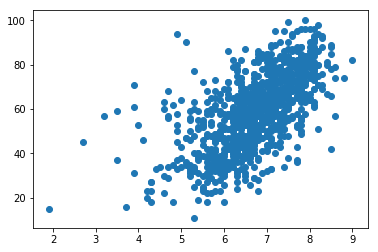

In [89]:
plt.scatter(db_movies['Rating'],db_movies['Metascore'])

Identify genres and create dataframes of movies in each genre

In [90]:
def getGenres(dataframe):
    genres = list()
    genreCol = dataframe['Genre']
    
    #Get the entry from the column
    for genreEnt in genreCol:
        #Split and parse strings of genre
        genreEntries = genreEnt.split(',')
        for genre in genreEntries:
            #check if it is in the list
            if not(any(genre in listEntry for listEntry in genres)):
                #Add to list if not included yet
                genres.append(genre)
    return genres

In [91]:
def hasGenre(row,genre):
    return genre in row['Genre']

Bar chart of genre frequency. Movies may be duplicated across genres

In [128]:
genreList = getGenres(db_movies)
genreFreq = list()

#Fill the requency dictionary genreFreq
for genre in genreList:
    freq = 0
    for index, row in db_movies.iterrows():
        if (hasGenre(row,genre)):
            freq += 1
    genreFreq.append((genre,freq))

#Sort dictionary by key into a tuple list
genreFreq.sort(key = lambda tup:tup[1],reverse=True)

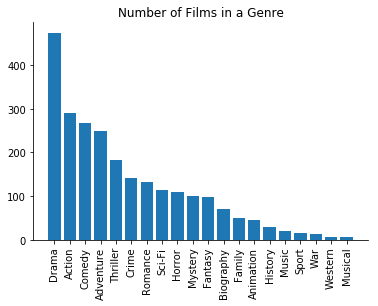

In [142]:
#Plot genreFreq as a bar chart
x = range(len(genreFreq))
x_label, y = zip(*genreFreq)

ax = plt.axes()

plt.bar(x, y, align='center',linewidth=0)
plt.xticks(x,x_label, rotation='vertical')
plt.title('Number of Films in a Genre')
ax.spines['right'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
plt.show()

Create new dataframes using the top five genres

In [152]:
def getGenreMovies(movies,genreList):
    movieTables = {}
    for genre in genreList:
        movieTables[genre] = movies.loc[movies['Genre'].str.contains(genre)]
    return movieTables

In [153]:
movieTb = getGenreMovies(db_movies,genreList)

In [176]:
#Get the correlation coefficients between ratings
genreCorr = list()
for genre in genreList:
    genreCorr.append((genre,movieTb[genre].corr()['Rating']['Metascore']))

In [177]:
[tup for tup in genreCorr if abs(tup[1]) < 0.5]

[('Horror', 0.4907297965929032),
 ('Music', 0.475652879054996),
 ('Biography', 0.35940753272590187)]

Plot histogram of differences in rating in movies for each genre

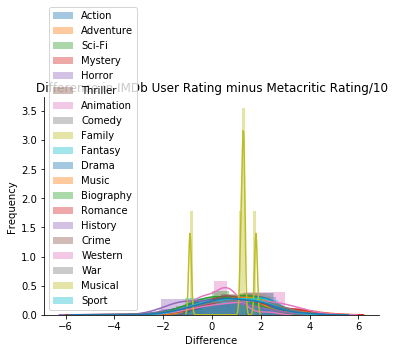

In [220]:
axi = plt.axes()

for genre,genre_df in movieTb.items():
    sns.distplot(genre_df['Difference'])
    

sns.distplot(db_movies['Difference'])

axi.legend(movieTb.keys())

plt.title('Difference in IMDb User Rating minus Metacritic Rating/10')
plt.ylabel('Frequency')
axi.spines['right'].set_linewidth(0)
axi.spines['top'].set_linewidth(0)

plt.show()

In [211]:
stats.ttest_ind(genre_df['Difference'], db_movies['Difference'], axis=0)

Ttest_indResult(statistic=4.4927353688385905, pvalue=7.69680299522382e-06)